<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Seq_2_Seq/Seq2Seq_Attention_Luong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Dans ce carnet nous allons mettre en place une attention de type Luong dans notre modèle de prédiction de séries temporelles Séquence vers Séquence.  
Le papier de recherche sur lequel s'appuie ce modèle est disponible ici : [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.124.191.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.191.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

**1. Chargement des données**

In [3]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Data/Power_PV.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   177  100   177    0     0    316      0 --:--:-- --:--:-- --:--:--   317
100 1790k  100 1790k    0     0  2154k      0 --:--:-- --:--:-- --:--:-- 19.3M


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_data = pd.read_csv("Power_PV.csv")
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229330,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384000,77.567340,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.200000,1.666067,929.0,0.0,0.0


Affiche les types :

In [5]:
df_data.dtypes

Date                       object
Temp. (°C)                float64
Humid. Rel (%)            float64
Vent (m/s)                float64
Pression (mbar)           float64
Ensolleillement (W/m2)    float64
watts                     float64
dtype: object

Converison des types `object` en `float32` :

In [6]:
df_data.iloc[:,1:] = pd.DataFrame.replace(df_data.iloc[:,1:],"?","NaN")
df_data.iloc[:,1:] = df_data.iloc[:,1:].astype(np.float32)
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.199997,1.666067,929.0,0.0,0.0


In [7]:
df_data.dtypes

Date                       object
Temp. (°C)                float32
Humid. Rel (%)            float32
Vent (m/s)                float32
Pression (mbar)           float32
Ensolleillement (W/m2)    float32
watts                     float32
dtype: object

In [8]:
# Définition des dates de début et de fin

date_debut = "2018-07-01 00:00:00"
date_fin = "2019-04-14 00:00:00"

# Place l'index du dataframe sur la colonne Date
df_data = df_data.rename(columns={'Unnamed: 0': "Date"})
df_data = df_data.set_index(df_data['Date'])

# Copie des données dans le dataframe d'étude sur l'intervalle d'étude
df_etude = df_data.loc[date_debut:date_fin].copy()

# Conversion de la colonne Date au format datetime
df_etude.index = pd.to_datetime(df_etude.index)

# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Date", axis=1)
df_etude

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
Date,,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0


Vérification des données et correction des anomalies :

In [9]:
data_manquantes = sum(np.isnan(df_etude['watts']))
print ("Données manquantes : %s" %data_manquantes)

Données manquantes : 62


In [10]:
df_etude = df_etude.fillna(method="backfill")

In [11]:
data_manquantes = sum(np.isnan(df_etude['watts']))
print ("Données manquantes : %s" %data_manquantes)

Données manquantes : 0


**5. Affiche les données**

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_etude.index,y=df_etude['watts'], line=dict(color='blue', width=1),name="Puissance (W)"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Analyse de la série

**1. ACF & PACF**

In [ ]:
# ACF & PACF du bruit blanc

serie = df_etude['watts'].values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,500))
ax1.set_title("Autocorrélation")

plot_pacf(serie, ax=ax2, lags = range(0, 500))
ax2.set_title("Autocorrélation partielle")

# Séparation des données de test et d'entrainement

In [13]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude['watts'].values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude['watts'].values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude['watts'].values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 22042
Taille de la validation : 5511


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [14]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
serie_entrainement_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_entrainement_X,shape=(len(serie_entrainement_X),1)))
serie_test_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_test_X,shape=(len(serie_test_X),1)))

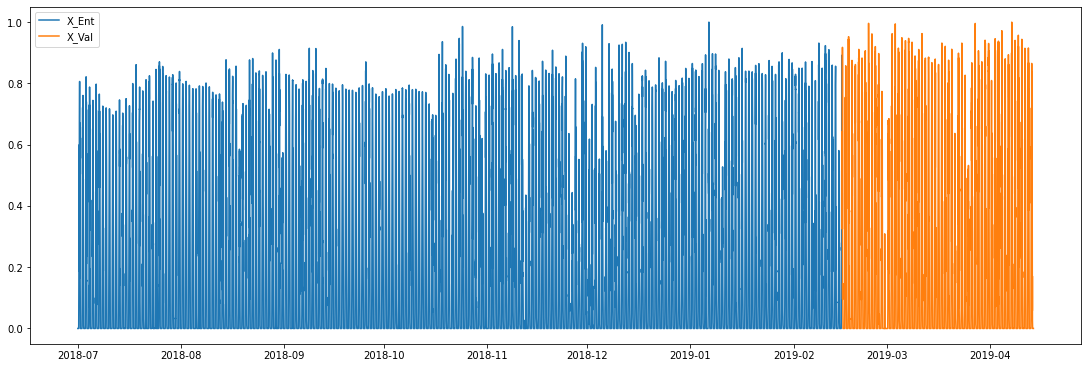

In [15]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm, label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm, label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [16]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, longueur_sequence, longueur_sortie, batch_size,shift):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  dataset = dataset.map(lambda x: (x[0:longueur_sequence][:,:],tf.expand_dims(x[-longueur_sortie:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [17]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 512
longueur_sequence = 5*24*4      # 5 jours (288*15min)
longueur_sortie = 12*4          # 12h
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)

In [18]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

42
(512, 480, 1)
(512, 48, 1)


In [19]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0].shape)
  print(element[1].shape)

9
(512, 480, 1)
(512, 48, 1)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [20]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,5,779),(32,5,1)) => x = 60x(32,5,779) ; y = 60x(32,5,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,5,779) => (60,32,5,779)
y = np.asarray(y,dtype=np.float32)      # 60x(32,5,1) => (60,32,5,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))     # (60,32,5,779) => (60*32,5,779)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))     # (60,32,5,1) => (60*32,5,1)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(21504, 480, 1)
(21504, 48, 1)


Puis la même chose pour les données de validation :

In [21]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))

# Recombine les données
x = np.asarray(x,dtype=np.float32)
y = np.asarray(y,dtype=np.float32)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(4608, 480, 1)
(4608, 48, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,3):
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[i],label="X_train")
  ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[i],label="Y_train")

ax.legend()
plt.show()

# Codage des couches du modèle Seq2Seq avec attention de Luong (avec encodeur simple GRU)

Notre modèle Séquence vers Séquence est composé :
- D'un encodeur, qui comprend une couche GRU uni-directionnelle
- D'un décodeur, qui comprend une couche GRU uni-directionnelle.
- D'un système d'attention de type Luong dont le but est de décider quelle est la partie de la source la plus importante à chaque étape du décodage.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_Attention_Luong_GRU2.png?raw=true' />

**1. Création de la couche d'attention**

L'attention est calculée à chaque étape du décodage. Le but est de décider quelles sont les parties les plus importante dans la source.  
Pour cela, à chaque étape du décodage le calcul d'attention est effectué de la manière suivante :
- L'attention reçoit l'ensemble des états cachés de l'encodeur Enc_out (batch_size, Tin, GRU) ainsi que l'état caché du décodeur à l'étape précédente Hid_state (batch_size,GRU)
- A partir de ces deux informations, elle calcule un score d'attention alpha. Ce score représente l'importance de l'état caché issu du décodeur à l'étape de décodage courante. Dans la méthode de Luong, ce score est calculé en recherchant les similarités entre le vecteur caché et les représentations cachées des différents vecteurs issus de l'encodeur.
- A partir des scores d'attention, elle calcule les poids d'attention à attribuer à chaque état caché de l'encodeur (Enc_out#1, Enc_out#2, ...). Ces poids représentent des probabilités et sont obtenus en appliquant une fonction de type Softmax sur les scores.
- Enfin, elle applique les poids d'attention sur les états cachés de l'encodeur en effectuant la somme pondérée de ces états cachés avec les poids.
- Le résultat obtenu est le vecteur contexte C qui sera ensuite concaténé avec l'entrée et injecté dans la cellule GRU de décodage.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/CalculAttentionLuong2.png?raw=true' />

In [23]:
# Classe d'attention de Luong

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self):
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(input_shape[2],input_shape[2]),initializer="normal",name="W")   # (#GRU, #GRU)
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Entrées : enc_out : Etats cachés de l'encodeur (batch_size, Tin, #GRU)
  #           hid_dec : Etat caché du décodeur (batch_size, #GRU)
  # Sortie :  vc :      Vecteur contexte (batch_size,#GRU) 
  def call(self,enc_out,hid_dec):
    # Calcul de Xh contenant les
    # représentations cachées des vecteurs
    # issus de l'encodeur
    xt = tf.transpose(enc_out,perm=[0,2,1])    # (batch_size,Tin,#GRU) => (batch_size,#GRU,Tin)
    Xh = tf.matmul(self.W,xt)                  # (#GRU,#GRU)x(batch_size,#GRU,Tin) = (batch_size,#GRU,Tin)

    # Calcul des poids d'attention normalisés
    Xh = tf.transpose(Xh,perm=[0,2,1])        # Xh = (batch_size,#GRU,Tin) => (batch_size,Tin,#GRU)
    hid_dec = tf.expand_dims(hid_dec,-1)      # (batch_size,#GRU) => (batch_size,#GRU,1)
    a = tf.matmul(Xh,hid_dec)                 # (batch_size,Tin,#GRU)x(batch_size,#GRU,1) = (batch_size,Tin,1)
    a = tf.keras.activations.softmax(a,axis=1)

    # Calcul du vecteur contexte
    xa = tf.multiply(enc_out,a)               # (batch_size,Tin,#GRU)_x_(batch_size,Tin,1) = (batch_size,Tin,#GRU)
    vc = K.sum(xa,axis=1)                     # vc = (batch_size,#GRU)
    return vc

**2. Création de la couche d'encodeur**

Dans le document de recherche de Luong, l'encodeur utilisé est de type GRU unidirectionnel.  

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Encodeur_Luong.png?raw=true' width=400/>

In [22]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=True,return_state=True,dropout=self.drop,recurrent_dropout=self.drop,name="GRU_Encodeur")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,Tin,1) 
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,Tin,#GRU)
  #     out_hid : Sortie vecteur caché  : (batch_size,#GRU)
  def call(self, input):
    out_enc, out_hid = self.couche_GRU(input)
    return out_enc, out_hid

**3. Création de la couche de décodeur**

On utilise un réseau de type GRU unidirectionnel et on réalise cette combinaison linéaire à l'extérieur du réseau. Dans le document de recherche de Luong, le vecteur contexte et le vecteur caché issu de la cellule GRU sont combinés ensemble en y appliquant un poids et une fonction tanh.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Decodeur_Luong.png?raw=true'/>

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="GRU_Decodeur")
    self.Wc = tf.keras.layers.Dense(units=self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=2*self.dim_GRU,activation="tanh",use_bias=False)
    self.couche_Dense_Generateur = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    self.Attention = Couche_Attention()
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     dec_input:    Entrée décodeur       : (batch_size,1,1) 
  #     enc_out:      Sortie encodeur       : (batch_size,Tin,#GRU)
  #     hidden:       Vecteur caché         : (batch_size,#GRU)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,#GRU)
  def call(self,dec_input, enc_out,hidden):
    # Calcul du hidden state courant
    out_dec, out_hid = self.couche_GRU(dec_input,initial_state=hidden)

    # Calcul du vecteur contexte
    vect_contexte = self.Attention(enc_out,out_hid)          # (batch_size,#GRU)

    # Concaténation du vecteur contexte
    # et du hidden state courant
    add = tf.concat([vect_contexte,out_hid],axis=1)        # Concat {(batch_size,#GRU),(batch_size,#GRU)} = ((batch_size,#2*GRU))

    # Application de la couche dense Wc
    out_dec = self.Wc(add)                                 # (batch_size,GRU)

    # Calcul de la sortie
    out_dec = self.couche_Dense_Generateur(out_dec)
    return out_dec, out_hid

**4. Création de la couche réseau**

Dans le document de recherche, l'état caché initial du décodeur est calculé à partir du premier état caché (sens retour) de l'encodeur. Ici, on calcule cet état initial en utlilisant le dernier état caché de l'encodeur. 

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_Attention_Luong_GRU2.png?raw=true' />

In [24]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Ws = tf.keras.layers.Dense(units=self.dim_GRU,activation="tanh",use_bias=False)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:      Entrée réseau         : (batch_size, Tin, 1) 
  #     output_seq  Sorties réelles       : (batch_size, longueur_sortie,1)
  # Sorties :
  def call(self,input,output_seq,training=False, proba=1.0):
    longueur_entree = input.shape[1]
    sortie = []

    # Encodage de la séquence d'entrée
    enc_out, enc_hid = self.encodeur(input)       # (batch_size,Tin,#GRU), (batch_size,#GRU)

    # Calcul de l'état caché initial du décodeur
    dec_hid = self.Ws(enc_hid)                    # s0 : (batch_size,#GRU)

    # La première entrée du décodeur est la
    # dernière entrée de l'encodeur
    dec_input = tf.expand_dims(input[:,-1,:],1)   # Y0 : (batch_size,1,1)

    if (training == False):
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, enc_out, dec_hid)
        dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    else:
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, enc_out, dec_hid)
        # Tirage au sort
        tirage = np.random.binomial(n=1,size=1,p=proba)
        if tirage == 1:
          dec_input = tf.expand_dims(output_seq[:,i,:],1)
        else:
          dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    return sortie

**5. Création du modèle avec Schedule Sampling**

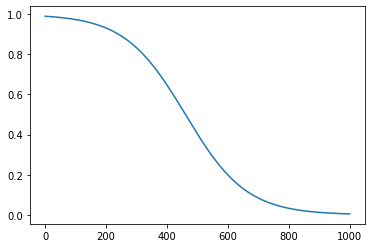

In [25]:
n_periodes = 1000

k = n_periodes/10       # Taux de décroissance

x = np.linspace(0,n_periodes,n_periodes+1)
y = k/(k+np.exp(x/k))

plt.plot(x,y)

In [27]:
dim_GRU = 128
drop=0.4
l2reg=0.01
max_periodes = 1000
k = max_periodes/10

class CustomModel(keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.periode = 0                  # Période courante
        self.k = k                        # Facteur de décroissance
        self.proba = 1.0                  # Proba du batch
        self.encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)
        self.decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)
        self.Net_GRU = Net_GRU(self.encodeur,self.decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)

    def call(self, inputs, training=False):
        sortie = self.Net_GRU(inputs[0],inputs[1],training=training, proba=self.proba)
        return sortie

    def train_step(self, data):
        x, y = data

        # Calcul de la probabilité courante pour ce batch
        self.proba = self.k/(self.k+np.exp(self.periode/self.k))
        self.periode = self.periode + 1

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Calcul du gradient
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Optimisation des poids
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        # Calcul des predictions
        y_pred = self(x, training=False)

        # Mise à jour des erreurs
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

# Entrainement avec TPU

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = CustomModel()

  # Définition de l'optimiseur à utiliser
  optimiseur=tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_opti.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
  historique = model.fit(x=[x_train,y_train],y=y_train,validation_data=([x_val,y_val],y_val), epochs=100,verbose=1, callbacks=CheckPoint,batch_size=batch_size)


In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [28]:
from google.colab import files

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = CustomModel()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=30,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train,y_train],y=y_train,validation_data=([x_val,y_val],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)],batch_size=batch_size)

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


NameError: ignored

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train,y_train],y=y_train)
model.evaluate(x=[x_val,y_val],y=y_val)

# Chargement du modèle pré-entrainé

**Seq2Seq_Luong_GRU128_DR04_L2_01_BS512_EP1000_DLR_001_5J_12H_SS10 :**
- Encodeur GRU unidirectionnel #128
- Longueur entrée : 5 jours
- Longueur sortie : 12h
- Drop : 0.4
- L2 : 0.01
- Batch Size : 512
- Périodes : 1000  
- Décroissance LR : 0.01  
- Schedule Sampling : k = max_periodes/10  
=> mse : 0.0105 / 0.0170
  
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Train_Luong.png?raw=true' width=500/>

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = CustomModel()
  model.compile(loss="mse",metrics="mse")
  model.fit(x=[x_train[0:1,:,:],y_train[0:1,:,:]],y=y_train[0:1,:,:], epochs=1)

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Modeles/Seq2Seq_Luong_GRU128_DR04_L2_01_BS512_EP1000_DLR_001_5J_12H_SS10.hdf5"

In [ ]:
model.load_weights("Seq2Seq_Luong_GRU128_DR04_L2_01_BS512_EP1000_DLR_001_5J_12H_SS10.hdf5")

# Prédictions multi-step

In [ ]:
pred_ent = model.predict([x_train,y_train],verbose=1)
pred_val = model.predict([x_val,y_val],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Affiche les courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

# Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))


#Calcul les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

# Affiche les prédictions
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Prédictions single-step

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()